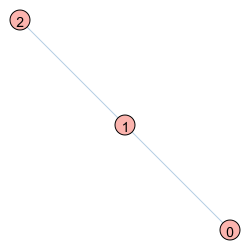

In [7]:
# Load packages
from igraph import *
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math


# Create a tree network using igraph method
G = Graph.Tree(3,1)


G.vs["name"] = [str(i) for i in range(len(G.vs))]

#transforming to dataframe
g = pd.DataFrame({'source': [x for e in G.es for x in (e.source, e.target)],
                  'target': [x for e in G.es for x in (e.target, e.source)]})
#plotting
p_style = {"bbox": (250, 250), "vertex_color": "#FBB4AE", "edge_color": "#B3CDE3"}
plot(G, layout=G.layout("kk"), vertex_label=G.vs["name"], **p_style)

In [8]:
# Parameters
# Transmission rate
beta = 0.5
# Recovery rate
gamma = 0.5
#Time 
T = 3
#Initial probability for infected node
p0 = pd.DataFrame({'node': g['source'].unique(), 'prob': 0})
p0.loc[p0['node'].isin([1]), 'prob'] = 1

In [16]:
def calculate_gamma_exponential(node, graph, a=0.1, b=0.1):
    degree = graph[(graph['source'] == node) | (graph['target'] == node)].shape[0]
    return a * math.exp(b * degree)

In [2]:
def SIR_EXMC(g, p0, beta, T, num_simulations):
    nodes = p0['node'].tolist()
    init_probs = p0['prob'].tolist()
    start = time.time()
    
    # Create a dictionary to store recovery rates for each node
    gamma_dict = {node: calculate_gamma_exponential(node, g) for node in nodes}

    # Extract nodes with a specific initial infection probability
    unique_prob = [prob for prob in set(init_probs) if prob != 0][0]
    initialized_nodes = p0[p0['prob'] == unique_prob]['node'].tolist()


    # Create neighbors dictionary
    neighbors = {node: set() for node in nodes}
    for row in g.itertuples():
        neighbors[row.source].add(row.target)
        neighbors[row.target].add(row.source)

    # Results arrays
    avg_mrg_s = np.zeros((T, len(nodes)))
    avg_mrg_i = np.zeros((T, len(nodes)))
    avg_mrg_r = np.zeros((T, len(nodes)))

    for simulation in range(num_simulations):
        # Initialize states as susceptible
        state = {node: 'S' for node in nodes}
        
        
        # Randomly infect other nodes based on probabilities
        for node, init_prob in zip(nodes, init_probs):
            if node in initialized_nodes and np.random.random() < init_prob:
                state[node] = 'I'

        # Count initial states before the simulation starts
        for i, node in enumerate(nodes):
            avg_mrg_s[0, i] += state[node] == 'S'
            avg_mrg_i[0, i] += state[node] == 'I'
            avg_mrg_r[0, i] += state[node] == 'R'

        # Simulation loop
        for t in range(1, T):
            new_state = state.copy()
            for i in nodes:
                if state[i] == 'I':
                    # Infect susceptible neighbors
                    for neighbor in neighbors[i]:
                        if state[neighbor] == 'S' and np.random.random() < beta:
                            new_state[neighbor] = 'I'
                    # Recovery
                    if np.random.random() < gamma_dict[i]:
                        new_state[i] = 'R'
            state = new_state

            # Count states at each time step
            for i, node in enumerate(nodes):
                avg_mrg_s[t, i] += state[node] == 'S'
                avg_mrg_i[t, i] += state[node] == 'I'
                avg_mrg_r[t, i] += state[node] == 'R'
                
            
                
    # Average the results across simulations
    avg_mrg_s /= num_simulations
    avg_mrg_i /= num_simulations
    avg_mrg_r /= num_simulations
    
   
    print("EXMC Runtime:   " + str(round(time.time() - start, 2)) + " seconds") 

    return avg_mrg_s, avg_mrg_i, avg_mrg_r

In [18]:
#observed_s, observed_i, observed_r = SIR_EXMC(g, p0, beta, T, 100000)

In [13]:
#observed_s

array([[1.     , 0.     , 1.     ],
       [0.50013, 0.     , 0.50124],
       [0.27722, 0.     , 0.27743]])

In [14]:
#observed_i

array([[0.     , 1.     , 0.     ],
       [0.49987, 0.89627, 0.49876],
       [0.6717 , 0.80219, 0.6711 ]])

In [15]:
#observed_r

array([[0.     , 0.     , 0.     ],
       [0.     , 0.10373, 0.     ],
       [0.05108, 0.19781, 0.05147]])